In [1]:
import pandas as pd
import os
from pathlib import Path
import matplotlib.pyplot as plt

In [2]:
def merge_physiological_data(base_path):
    all_data = []
    base_path = Path(base_path)
    
    for condition in ['hypoxia', 'regular']:
        condition_path = base_path / condition
        
        if not condition_path.exists():
            continue
            
        for group_dir in condition_path.iterdir():
            if not group_dir.is_dir():
                continue
                
            group_id = group_dir.name
            bpm_path = group_dir / 'bpm'
            uterus_path = group_dir / 'uterus'
            
            if not (bpm_path.exists() and uterus_path.exists()):
                continue
            
            bpm_files = {f.stem: f for f in bpm_path.glob('*.csv')}
            uterus_files = {f.stem: f for f in uterus_path.glob('*.csv')}
            
            for base_name in bpm_files.keys(): # [_1, _3]
                uterus_base = base_name.replace('_1', '_2').replace('_3', '_4') # [_1, _3] -> [_2, _4]
                
                if uterus_base in uterus_files:
                    bpm_df = pd.read_csv(bpm_files[base_name])
                    bpm_df.columns = ['time_sec', 'bpm']
                    uterus_df = pd.read_csv(uterus_files[uterus_base])
                    uterus_df.columns = ['time_sec', 'uterus']
                    merged = pd.merge(bpm_df, uterus_df, on='time_sec', how='inner')
                    merged['group_id'] = group_id
                    merged['sequence_id'] = base_name
                    merged['target'] = condition
                    merged['timestamp'] = merged['time_sec']
                    merged = merged[['timestamp', 'group_id', 'sequence_id', 'bpm', 'uterus', 'target']]
                    all_data.append(merged)
                    # print(f"Processed: {condition}/{group_id}/{base_name}")
                        
    if all_data:
        final_df = pd.concat(all_data, ignore_index=True)
        return final_df
    else:
        return pd.DataFrame()

base_directory = "/kaggle/input/govno-ot-itelmi/govno_ot_itelmi"
merged_data = merge_physiological_data(base_directory)

In [3]:
merged_data = merged_data.sort_values(by=['group_id', 'sequence_id', 'timestamp'])

In [4]:
merged_data.target.value_counts(normalize=True)

target
regular    0.67275
hypoxia    0.32725
Name: proportion, dtype: float64

In [5]:
merged_data['key'] = merged_data['group_id'] + ':' + merged_data['sequence_id']

In [6]:
def plot_ts(merged_data, group_id, seq_id):
    data_subset = merged_data[(merged_data['group_id'] == group_id) & (merged_data['sequence_id'] == seq_id)]
    
    plt.figure(figsize=(10, 4))
    plt.subplot(2, 1, 1)
    plt.plot(data_subset['timestamp'], data_subset['bpm'], 'b-', linewidth=1)
    plt.ylabel('BPM')
    plt.title(f'Physiological Data - Group {group_id}, Sequence Id {seq_id}')
    plt.grid(True, alpha=0.3)
    
    plt.subplot(2, 1, 2)
    plt.plot(data_subset['timestamp'], data_subset['uterus'], 'r-', linewidth=1)
    plt.ylabel('Uterus')
    plt.xlabel('Time (seconds)')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

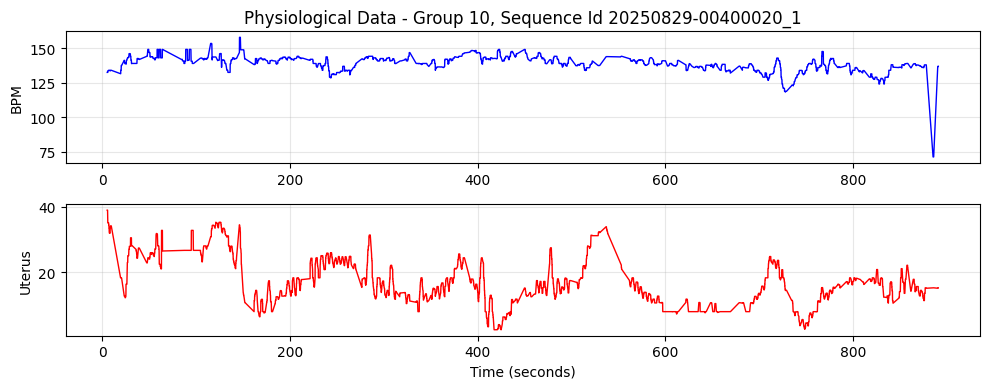

In [7]:
random_row = merged_data.sample(1)
random_group_id, random_seq_id = random_row.group_id.iloc[0], random_row.sequence_id.iloc[0]
plot_ts(merged_data=merged_data, group_id=random_group_id, seq_id=random_seq_id)

In [8]:
sequence_lengths = merged_data.groupby(['group_id', 'sequence_id']).size().reset_index(name='length')

In [9]:
sequence_lengths.length.min()

1

In [10]:
THOLD = 100

In [11]:
len(sequence_lengths[sequence_lengths['length'] < THOLD]) / len(sequence_lengths)

0.10168302945301542

In [12]:
gs_to_drop = sequence_lengths[sequence_lengths['length'] < THOLD][['group_id', 'sequence_id']]
gs_to_drop['key'] = gs_to_drop['group_id'] + ':' + gs_to_drop['sequence_id']

In [13]:
gs_to_drop

,group_id,sequence_id,key
65,10,20250908-07400012_1,10:20250908-07400012_1
66,10,20250908-07400013_1,10:20250908-07400013_1
67,10,20250908-07400014_1,10:20250908-07400014_1
68,10,20250908-07400016_1,10:20250908-07400016_1
91,103,20250909-00500008_1,103:20250909-00500008_1
...,...,...,...
1272,50,20250909-01100003_1,50:20250909-01100003_1
1293,50,20250909-01100026_1,50:20250909-01100026_1
1294,50,20250909-01100027_1,50:20250909-01100027_1
1296,50,20250909-01100029_1,50:20250909-01100029_1


In [14]:
merged_data[~merged_data['key'].isin(gs_to_drop['key'])]

,timestamp,group_id,sequence_id,bpm,uterus,target,key
2993113,0.000000,1,20250901-01000001_1,210.000000,67.056530,regular,1:20250901-01000001_1
2993114,0.127029,1,20250901-01000001_1,210.000000,67.056530,regular,1:20250901-01000001_1
2993115,0.254058,1,20250901-01000001_1,210.000000,67.056530,regular,1:20250901-01000001_1
2993116,0.381087,1,20250901-01000001_1,210.000000,67.056530,regular,1:20250901-01000001_1
2993117,0.508116,1,20250901-01000001_1,210.000000,6.887589,regular,1:20250901-01000001_1
...,...,...,...,...,...,...,...
999592,219.760056,9,20250908-08200019_1,188.278995,8.382066,hypoxia,9:20250908-08200019_1
999593,271.968948,9,20250908-08200019_1,188.236237,98.310591,hypoxia,9:20250908-08200019_1
999594,272.095977,9,20250908-08200019_1,188.236237,98.310591,hypoxia,9:20250908-08200019_1
999595,272.223006,9,20250908-08200019_1,188.236237,98.310591,hypoxia,9:20250908-08200019_1


In [15]:
3566085 - 3560830

5255

In [16]:
THOLD / 5

20.0

In [17]:
merged_data = merged_data[~merged_data['key'].isin(gs_to_drop['key'])]

In [18]:
sequence_lengths = merged_data.groupby(['group_id', 'sequence_id']).size().reset_index(name='length')

In [19]:
sequence_lengths.length.min()

104

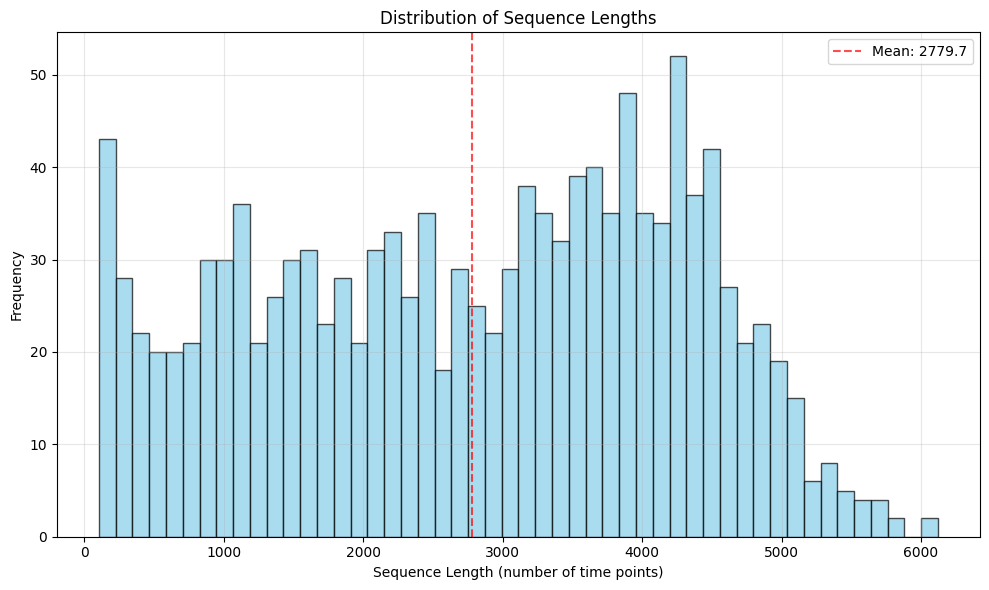

In [20]:
plt.figure(figsize=(10, 6))
plt.hist(sequence_lengths['length'], bins=50, alpha=0.7, edgecolor='black', color='skyblue')
plt.xlabel('Sequence Length (number of time points)')
plt.ylabel('Frequency')
plt.title('Distribution of Sequence Lengths')
plt.grid(True, alpha=0.3)

mean_length = sequence_lengths['length'].mean()
plt.axvline(mean_length, color='red', linestyle='--', alpha=0.7, label=f'Mean: {mean_length:.1f}')

plt.legend()
plt.tight_layout()
plt.show()

In [21]:
merged_data.sequence_id.nunique()

1269

In [22]:
merged_data['target'] = merged_data['target'].map({'regular': 0, 'hypoxia': 1})

In [23]:
merged_data

,timestamp,group_id,sequence_id,bpm,uterus,target,key
2993113,0.000000,1,20250901-01000001_1,210.000000,67.056530,0,1:20250901-01000001_1
2993114,0.127029,1,20250901-01000001_1,210.000000,67.056530,0,1:20250901-01000001_1
2993115,0.254058,1,20250901-01000001_1,210.000000,67.056530,0,1:20250901-01000001_1
2993116,0.381087,1,20250901-01000001_1,210.000000,67.056530,0,1:20250901-01000001_1
2993117,0.508116,1,20250901-01000001_1,210.000000,6.887589,0,1:20250901-01000001_1
...,...,...,...,...,...,...,...
999592,219.760056,9,20250908-08200019_1,188.278995,8.382066,1,9:20250908-08200019_1
999593,271.968948,9,20250908-08200019_1,188.236237,98.310591,1,9:20250908-08200019_1
999594,272.095977,9,20250908-08200019_1,188.236237,98.310591,1,9:20250908-08200019_1
999595,272.223006,9,20250908-08200019_1,188.236237,98.310591,1,9:20250908-08200019_1


In [24]:
import numpy as np

In [25]:
def fast_seq_agg(df):
    sc = ['key', 'sequence_id', 'group_id', 'target']
    seq_cols = [c for c in df.columns if c not in sc + ['timestamp']]
    static_cols = [c for c in sc if c in df.columns]

    df = df.sort_values(['sequence_id', 'timestamp']).reset_index(drop=True)

    seq_id_codes, _ = pd.factorize(df['sequence_id'])
    _, seq_start_idxs = np.unique(seq_id_codes, return_index=True)

    res = {'sequence_id': df['sequence_id'].values[seq_start_idxs]}

    for c in static_cols:
        res[c] = df[c].values[seq_start_idxs]

    for c in seq_cols:
        res[c] = np.split(df[c].values, seq_start_idxs[1:])

    res_df = pd.DataFrame(res)
    
    return res_df

In [26]:
merged_data = fast_seq_agg(merged_data)

In [27]:
merged_data

,sequence_id,key,group_id,target,bpm,uterus
0,20250828-00500001_1,30:20250828-00500001_1,30,1,"[133.121325, 133.121325, 134.147515, 134.14751...","[10.865322, 10.865322, 10.865322, 10.865322, 1..."
1,20250828-00500002_1,30:20250828-00500002_1,30,1,"[134.579989, 134.579989, 134.579989, 134.57998...","[26.497396, 26.236979, 26.236979, 26.106771, 2..."
2,20250828-00500003_1,30:20250828-00500003_1,30,1,"[134.172239, 134.172239, 134.172239, 134.17223...","[10.409889, 10.409889, 10.670137, 10.670137, 1..."
3,20250828-00500004_1,30:20250828-00500004_1,30,1,"[143.183521, 143.183521, 143.183521, 143.18352...","[10.807292, 10.9375, 10.9375, 10.9375, 10.9375..."
4,20250828-00500005_1,30:20250828-00500005_1,30,1,"[131.733084, 131.733084, 131.818668, 131.81866...","[11.053316, 11.183355, 11.183355, 11.183355, 1..."
...,...,...,...,...,...,...
1264,20250915-00600019_1,25:20250915-00600019_1,25,1,"[157.022982, 157.06574, 157.06574, 157.06574, ...","[21.312541, 21.247563, 21.182586, 21.182586, 2..."
1265,20250915-00600020_1,25:20250915-00600020_1,25,1,"[154.329236, 154.329236, 154.329236, 154.32923...","[15.055159, 15.055159, 15.055159, 14.925373, 1..."
1266,20250915-00600021_1,25:20250915-00600021_1,25,1,"[140.946018, 140.946018, 140.946018, 140.94601...","[5.451006, 5.451006, 5.451006, 5.451006, 5.451..."
1267,20250915-00600022_1,25:20250915-00600022_1,25,1,"[157.06574, 157.06574, 157.06574, 157.06574, 1...","[14.795587, 14.795587, 14.795587, 14.795587, 1..."


In [28]:
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.preprocessing import StandardScaler

In [29]:
seq_len = 5000
seed = 228
n_folds = 5
num_classes = 2

In [30]:
sgkf = StratifiedGroupKFold(n_splits=n_folds, shuffle=True, random_state=seed)
merged_data['fold'] = -1

for fold, (train_idx, val_idx) in enumerate(sgkf.split(merged_data, merged_data['target'], merged_data['group_id'])):
    merged_data.loc[val_idx, 'fold'] = fold

In [31]:
def scale_per_fold(df, cols=['bpm', 'uterus'], n_folds=5, eps=1e-8):
    df_scaled = df.copy()
    for f in range(n_folds):
        train_mask = df['fold'] != f
        val_mask = df['fold'] == f
        for c in cols:
            all_vals = []
            for idx in df[train_mask].index:
                all_vals.extend(df.loc[idx, c])
            all_vals = np.asarray(all_vals, dtype=float)
            mean = all_vals.mean() if all_vals.size > 0 else 0.0
            std = all_vals.std() if all_vals.size > 0 else 1.0
            std = max(std, eps)
            for idx in df[val_mask].index:
                seq = np.asarray(df.loc[idx, c], dtype=float)
                df_scaled.at[idx, c] = (seq - mean) / std
    return df_scaled

In [32]:
merged_data = scale_per_fold(merged_data)

In [33]:
import torch
from torch.utils.data import Dataset

In [34]:
import numpy as np
from scipy.interpolate import CubicSpline

def jitter(x, sigma=0.05, prikol='gauss'):
    if prikol == 'laplace':
        return x + np.random.laplace(loc=0., scale=sigma, size=x.shape)
    return x + np.random.normal(loc=0., scale=sigma, size=x.shape)

def scaling_aug(x, sigma=0.1):
    x = np.expand_dims(x, axis=0)
    factor = np.random.normal(loc=1., scale=sigma, size=(x.shape[0], x.shape[2]))
    output = np.multiply(x, factor[:, np.newaxis, :])
    return np.squeeze(output, axis=0)

def magnitude_warp(x, sigma=0.2, knot=4):
    x = np.expand_dims(x, axis=0)
    orig_steps = np.arange(x.shape[1])
    random_warps = np.random.normal(loc=1.0, scale=sigma, size=(x.shape[0], knot+2, x.shape[2]))
    warp_steps = (np.ones((x.shape[2],1))*(np.linspace(0, x.shape[1]-1., num=knot+2))).T
    ret = np.zeros_like(x)
    for i, pat in enumerate(x):
        warper = np.array([CubicSpline(warp_steps[:,dim], random_warps[i,:,dim])(orig_steps) for dim in range(x.shape[2])]).T
        ret[i] = pat * warper
    return np.squeeze(ret, axis=0)

def time_warp(x, sigma=0.2, knot=4):
    x = np.expand_dims(x, axis=0)
    orig_steps = np.arange(x.shape[1])
    random_warps = np.random.normal(loc=1.0, scale=sigma, size=(x.shape[0], knot+2, x.shape[2]))
    warp_steps = (np.ones((x.shape[2],1))*(np.linspace(0, x.shape[1]-1., num=knot+2))).T
    ret = np.zeros_like(x)
    for i, pat in enumerate(x):
        for dim in range(x.shape[2]):
            time_warp_ = CubicSpline(warp_steps[:,dim], warp_steps[:,dim] * random_warps[i,:,dim])(orig_steps)
            scale = (x.shape[1]-1)/time_warp_[-1]
            ret[i,:,dim] = np.interp(orig_steps, np.clip(scale*time_warp_, 0, x.shape[1]-1), pat[:,dim]).T
    return np.squeeze(ret, axis=0)

def window_slice(x, reduce_ratio=0.9):
    x = np.expand_dims(x, axis=0)
    target_len = np.ceil(reduce_ratio*x.shape[1]).astype(int)
    if target_len >= x.shape[1]:
        return np.squeeze(x, axis=0)
    starts = np.random.randint(low=0, high=x.shape[1]-target_len, size=(x.shape[0])).astype(int)
    ends = (target_len + starts).astype(int)
    ret = np.zeros_like(x)
    for i, pat in enumerate(x):
        for dim in range(x.shape[2]):
            ret[i,:,dim] = np.interp(np.linspace(0, target_len, num=x.shape[1]), np.arange(target_len), pat[starts[i]:ends[i],dim]).T
    return np.squeeze(ret, axis=0)

def window_warp(x, window_ratio=0.1, scales=[0.5, 2.]):
    x = np.expand_dims(x, axis=0)
    warp_scales = np.random.choice(scales, x.shape[0])
    warp_size = np.ceil(window_ratio*x.shape[1]).astype(int)
    window_steps = np.arange(warp_size)
    window_starts = np.random.randint(low=1, high=x.shape[1]-warp_size-1, size=(x.shape[0])).astype(int)
    window_ends = (window_starts + warp_size).astype(int)
    ret = np.zeros_like(x)
    for i, pat in enumerate(x):
        for dim in range(x.shape[2]):
            start_seg = pat[:window_starts[i],dim]
            window_seg = np.interp(np.linspace(0, warp_size-1, num=int(warp_size*warp_scales[i])), window_steps, pat[window_starts[i]:window_ends[i],dim])
            end_seg = pat[window_ends[i]:,dim]
            warped = np.concatenate((start_seg, window_seg, end_seg))
            ret[i,:,dim] = np.interp(np.arange(x.shape[1]), np.linspace(0, x.shape[1]-1., num=warped.size), warped).T
    return np.squeeze(ret, axis=0)

In [35]:
class TSDataset(Dataset):
    def __init__(self, df, seq_len=5000, augment=False, denoise=True):
        self.df = df.reset_index(drop=True)
        self.seq_len = seq_len
        self.augment = augment
        self.denoise = denoise

        self.augmentations = [
            ('jitter', lambda x: jitter(x, sigma=0.05), 0.7),
            ('time_warp', lambda x: time_warp(x, sigma=0.2, knot=4), 0.5),
            ('scaling', lambda x: scaling_aug(x, sigma=0.1), 0.4),
            ('magnitude_warp', lambda x: magnitude_warp(x, sigma=0.2, knot=4), 0.3),
            ('window_slice', lambda x: window_slice(x, reduce_ratio=0.9), 0.3),
            ('window_warp', lambda x: window_warp(x, window_ratio=0.1, scales=[0.5, 2.]), 0.3)
        ]

    def __len__(self):
        return len(self.df)

    def maybe_augment(self, sequence):
        if not self.augment:
            return sequence
        seq_aug = sequence.copy()
        for _, aug_func, prob in self.augmentations:
            if np.random.random() < prob:
                seq_aug = aug_func(seq_aug)
        return seq_aug

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        bpm_seq = np.asarray(row['bpm'], dtype=float)
        uterus_seq = np.asarray(row['uterus'], dtype=float)

        min_len = min(len(bpm_seq), len(uterus_seq))
        bpm_seq = bpm_seq[:min_len]
        uterus_seq = uterus_seq[:min_len]

        target = np.stack([bpm_seq, uterus_seq], axis=1)

        if self.augment and self.denoise:
            x_in = self.maybe_augment(target)
        else:
            x_in = target if not self.augment else self.maybe_augment(target)

        if x_in.shape[0] > self.seq_len:
            x_in = x_in[-self.seq_len:]
            target = target[-self.seq_len:]
        if x_in.shape[0] < self.seq_len:
            pad_len = self.seq_len - x_in.shape[0]
            x_in = np.concatenate([np.zeros((pad_len, 2)), x_in], axis=0)
            target = np.concatenate([np.zeros((pad_len, 2)), target], axis=0)

        return {
            'input': torch.tensor(x_in, dtype=torch.float32),    # (L, 2)
            'target': torch.tensor(target, dtype=torch.float32), # (L, 2)
            'idx': idx
        }

In [36]:
dataset = TSDataset(merged_data, seq_len=seq_len, augment=True, denoise=True)

In [37]:
dataset[2]

{'input': tensor([[ 0.0000,  0.0000],
         [ 0.0000,  0.0000],
         [ 0.0000,  0.0000],
         ...,
         [-0.0116, -0.1617],
         [-0.0116, -0.1619],
         [-0.0117, -0.1622]]),
 'target': tensor([[ 0.0000,  0.0000],
         [ 0.0000,  0.0000],
         [ 0.0000,  0.0000],
         ...,
         [-0.0123, -0.2177],
         [-0.0123, -0.2177],
         [-0.0123, -0.2177]]),
 'idx': 2}

In [38]:
import torch.nn as nn

In [39]:
class ConvBlock1D(nn.Module):
    def __init__(self, in_ch, out_ch, dropout=0.0):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(in_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm1d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv1d(out_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm1d(out_ch),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout) if dropout > 0 else nn.Identity(),
        )

    def forward(self, x):
        return self.conv(x)

In [40]:
class UNet1D(nn.Module):
    def __init__(self, in_channels=2, base_ch=16, depth=3, dropout=0.1, out_channels=2):
        super().__init__()
        chs = [base_ch * (2**i) for i in range(depth)]
        self.enc_blocks = nn.ModuleList()
        self.pools = nn.ModuleList()
        prev = in_channels
        for c in chs:
            self.enc_blocks.append(ConvBlock1D(prev, c, dropout=dropout))
            self.pools.append(nn.MaxPool1d(kernel_size=2))
            prev = c

        self.bottleneck = ConvBlock1D(prev, prev*2, dropout=dropout)

        self.upconvs = nn.ModuleList()
        self.dec_blocks = nn.ModuleList()
        dec_chs = list(reversed(chs))
        prev_dec = prev*2
        for c in dec_chs:
            self.upconvs.append(nn.ConvTranspose1d(prev_dec, c, kernel_size=2, stride=2))
            self.dec_blocks.append(ConvBlock1D(prev_dec, c, dropout=dropout))
            prev_dec = c

        self.out_conv = nn.Conv1d(prev_dec, out_channels, kernel_size=1)

    def forward(self, x):
        x = x.permute(0, 2, 1)
        skips = []
        for enc, pool in zip(self.enc_blocks, self.pools):
            x = enc(x)
            skips.append(x)
            x = pool(x)
        x = self.bottleneck(x)
        for up, dec, skip in zip(self.upconvs, self.dec_blocks, reversed(skips)):
            x = up(x)
            if x.size(-1) != skip.size(-1):
                diff = skip.size(-1) - x.size(-1)
                if diff > 0:
                    x = nn.functional.pad(x, (0, diff))
                else:
                    x = x[..., :skip.size(-1)]
            x = torch.cat([skip, x], dim=1)
            x = dec(x)
        x = self.out_conv(x)
        x = x.permute(0, 2, 1)
        return x

In [41]:
def batch_mae(pred, target):
    return torch.mean(torch.abs(pred - target))

def batch_mse(pred, target):
    return torch.mean((pred - target) ** 2)

def per_sample_recon_error(pred, target, reduction='mean'):
    err = torch.abs(pred - target) if reduction == 'mae' else (pred - target)**2
    if reduction in ('mean', 'mae', 'mse'):
        return err.mean(dim=(1,2))  # (B,)
    elif reduction == 'sum':
        return err.sum(dim=(1,2))
    else:
        return err.view(err.size(0), -1).mean(dim=1)

In [42]:
do_wandb_log = False
wandb_api_key = '...'

In [43]:
use_denoising = True

In [45]:
max_norm = 1.0

In [46]:
bs = 64
lr = 1e-4
n_epochs = 50
weight_decay = 1e-3
patience = 5
num_warmup_steps_ratio = 0.05

In [47]:
import random, os
import numpy as np
import torch

def seed_everything(seed: int = seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

In [48]:
def kalman_1d(z: np.ndarray,
              Q: float = 1e-5,
              R: float = 1e-2,
              x0: float | None = None,
              P0: float = 1.0) -> np.ndarray:
    n = len(z)
    x_hat = np.empty(n)
    x_est = z[0] if x0 is None else x0
    P = P0
    for k in range(n):
        x_pred = x_est
        P = P + Q
        K = P / (P + R)
        x_est = x_pred + K * (z[k] - x_pred)
        P = (1.0 - K) * P
        x_hat[k] = x_est
    return x_hat

def apply_kalman_to_sequences(df: pd.DataFrame,
                              sensor_cols: list[str] = ['bpm', 'uterus'],
                              Q: float = 1e-5,
                              R: float = 1e-2) -> pd.DataFrame:
    out = df.copy()
    for col in sensor_cols:
        if col in out.columns:
            out[col] = out[col].apply(
                lambda seq: kalman_1d(np.asarray(seq, dtype=float), Q=Q, R=R)
            )
    return out

In [49]:
do_kalman = True

In [50]:
import os
import json
import gc

import pandas as pd
import numpy as np

from tqdm import tqdm

from sklearn.model_selection import GroupKFold

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from transformers import get_cosine_schedule_with_warmup

import wandb

seed_everything()
g = torch.Generator(device='cpu').manual_seed(seed)

if do_wandb_log:
    os.environ['WANDB_API_KEY'] = wandb_api_key

train_seq = merged_data
if do_kalman:
    train_seq = apply_kalman_to_sequences(merged_data)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def train_epoch(train_loader, model, optimizer, criterion, device, scheduler, current_step=0, num_warmup_steps=0, fold=None):
    model.train()
    total_mae = 0.0
    total_mse = 0.0
    total_samples = 0

    loop = tqdm(train_loader, desc='train', leave=False)
    for batch in loop:
        optimizer.zero_grad()
        x = batch['input'].to(device)
        y = batch['target'].to(device)

        out = model(x)
        loss = criterion(out, y)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=max_norm)
        optimizer.step()
        scheduler.step()

        with torch.no_grad():
            mae = torch.mean(torch.abs(out - y)).item()
            mse = torch.mean((out - y)**2).item()

        bsz = x.size(0)
        total_mae += mae * bsz
        total_mse += mse * bsz
        total_samples += bsz

        loop.set_postfix(mae=mae, mse=mse)
        current_step += 1

    return total_mae/total_samples, total_mse/total_samples, current_step

@torch.no_grad()
def valid_epoch(val_loader, model, criterion, device):
    model.eval()
    total_mae = 0.0
    total_mse = 0.0
    total_samples = 0

    loop = tqdm(val_loader, desc='val', leave=False)
    for batch in loop:
        x = batch['input'].to(device)
        y = batch['target'].to(device)
        out = model(x)
        mae = torch.mean(torch.abs(out - y)).item()
        mse = torch.mean((out - y)**2).item()

        bsz = x.size(0)
        total_mae += mae * bsz
        total_mse += mse * bsz
        total_samples += bsz

        loop.set_postfix(mae=mae, mse=mse)

    return total_mae/total_samples, total_mse/total_samples

def average_model_weights(checkpoints, top_k):
    if len(checkpoints) < top_k:
        top_k = len(checkpoints)
    top_checkpoints = checkpoints[:top_k]
    averaged_state_dict = {}

    first_state_dict = torch.load(top_checkpoints[0]['model_path'], map_location=device)
    for key in first_state_dict.keys():
        averaged_state_dict[key] = torch.zeros_like(first_state_dict[key], dtype=torch.float)

    for checkpoint in top_checkpoints:
        state_dict = torch.load(checkpoint['model_path'], map_location=device)
        for key in state_dict.keys():
            averaged_state_dict[key] += state_dict[key].float() / top_k

    return averaged_state_dict

@torch.no_grad()
def get_oof_recon_and_errors(model, loader, device, reduction='mean'):
    model.eval()
    all_idx = []
    all_err = []
    for batch in loader:
        x = batch['input'].to(device)
        y = batch['target'].to(device)
        idx = batch['idx'].numpy()
        out = model(x)
        err = per_sample_recon_error(out, y, reduction='mean').cpu().numpy()
        all_idx.append(idx)
        all_err.append(err)
    all_idx = np.concatenate(all_idx, axis=0)
    all_err = np.concatenate(all_err, axis=0)
    return all_idx, all_err

def compute_threshold(errors: np.ndarray, method='percentile', p=95):
    if method == 'percentile':
        return np.percentile(errors, p)
    raise ValueError('unknown method')

def detect_anomalies(errors: np.ndarray, threshold: float):
    return (errors > threshold).astype(np.int8)

def run_training_with_group_kfold():
    model_dir = '/kaggle/working/'
    oof_dir = '/kaggle/working/'

    prefix = 'ae_unet1d_'

    gkf = GroupKFold(n_splits=n_folds)
    groups = train_seq['group_id'].values

    oof_errors = np.zeros(len(train_seq), dtype=np.float32)

    for fold, (train_idx, val_idx) in enumerate(gkf.split(train_seq, groups=groups)):
        print(f'fold {fold+1}/{n_folds}')

        train_subset = train_seq.iloc[train_idx].reset_index(drop=True)
        val_subset = train_seq.iloc[val_idx].reset_index(drop=True)

        train_dataset = TSDataset(df=train_subset, seq_len=seq_len, augment=True, denoise=use_denoising)
        val_dataset   = TSDataset(df=val_subset,   seq_len=seq_len, augment=False, denoise=False)

        g = torch.Generator(device='cpu').manual_seed(seed)

        train_loader = DataLoader(
            train_dataset,
            batch_size=bs,
            shuffle=True,
            pin_memory=True,
            persistent_workers=True,
            prefetch_factor=4,
            num_workers=4,
            generator=g,
            worker_init_fn=lambda worker_id: np.random.seed(seed + worker_id)
        )
        val_loader = DataLoader(
            val_dataset,
            batch_size=bs,
            shuffle=False,
            pin_memory=True,
            persistent_workers=True,
            prefetch_factor=4,
            num_workers=4,
            generator=g,
            worker_init_fn=lambda worker_id: np.random.seed(seed + worker_id)
        )

        model = UNet1D(in_channels=2, base_ch=16, depth=3, dropout=0.1, out_channels=2).to(device)
        optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
        criterion = nn.L1Loss()

        num_training_steps = n_epochs * len(train_loader)
        num_warmup_steps = int(num_warmup_steps_ratio * num_training_steps)
        current_step = 0

        scheduler_params = {
            'optimizer': optimizer,
            'num_warmup_steps': num_warmup_steps,
            'num_training_steps': num_training_steps
        }
        scheduler = get_cosine_schedule_with_warmup(**scheduler_params)

        best_val_mae = float('inf')
        patience_counter = 0
        fold_checkpoints = []

        for epoch in range(n_epochs):
            print(f'epoch={epoch}')
            train_mae, train_mse, current_step = train_epoch(train_loader, model, optimizer, criterion, device, scheduler, current_step, num_warmup_steps, fold)
            val_mae, val_mse = valid_epoch(val_loader, model, criterion, device)

            print(f'train_mae={train_mae:.6f}, train_mse={train_mse:.6f}')
            print(f'val_mae={val_mae:.6f}, val_mse={val_mse:.6f}')

            model_path = os.path.join(model_dir, f'{prefix}fold{fold}_val_mae_{val_mae:.6f}_epoch{epoch:03d}.pt')
            torch.save(model.state_dict(), model_path)
            fold_checkpoints.append({'score': -val_mae, 'epoch': epoch, 'model_path': model_path})
            fold_checkpoints.sort(key=lambda x: x['score'], reverse=True)

            if len(fold_checkpoints) > 5:
                to_remove = fold_checkpoints[5:]
                fold_checkpoints = fold_checkpoints[:5]
                for checkpoint in to_remove:
                    if os.path.exists(checkpoint['model_path']):
                        os.remove(checkpoint['model_path'])

            if val_mae < best_val_mae:
                best_val_mae = val_mae
                patience_counter = 0
            else:
                patience_counter += 1

            if patience_counter >= patience:
                print('early stopping')
                break

        best_checkpoint = fold_checkpoints[0]
        model.load_state_dict(torch.load(best_checkpoint['model_path'], map_location=device))

        idxs, errs = get_oof_recon_and_errors(model, val_loader, device, reduction='mean')
        global_indices = val_subset.index.values[idxs]
        oof_errors[global_indices] = errs

        del model, optimizer, scheduler, criterion
        del train_dataset, val_dataset, train_loader, val_loader
        gc.collect()
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

    oof_errors_path = os.path.join(oof_dir, f'{prefix}oof_recon_errors.npy')
    np.save(oof_errors_path, oof_errors)

    threshold = compute_threshold(oof_errors, method='percentile', p=95)
    print(f'OOF threshold (95p): {threshold:.6f}')

    oof_anoms = detect_anomalies(oof_errors, threshold)
    oof_info = {
        'oof_mae_mean': float(np.mean(oof_errors)),
        'oof_mae_std': float(np.std(oof_errors)),
        'threshold_95p': float(threshold),
        'oof_anomaly_rate': float(oof_anoms.mean())
    }
    oof_info_path = os.path.join(oof_dir, f'{prefix}oof_info.json')
    with open(oof_info_path, 'w') as f:
        json.dump(oof_info, f, indent=2)

    return oof_errors, threshold

def train_final_model_on_all_data(N_TOTAL_EPOCHS=36):
    model_dir = '/kaggle/working/'
    oof_dir = '/kaggle/working/'

    prefix = 'ae_unet1d_'
    
    dataset = TSDataset(df=train_seq, seq_len=seq_len, augment=True, denoise=use_denoising)
    g = torch.Generator(device='cpu').manual_seed(seed)

    loader = DataLoader(
        dataset,
        batch_size=bs,
        shuffle=True,
        pin_memory=True,
        persistent_workers=True,
        prefetch_factor=4,
        num_workers=4,
        generator=g,
        worker_init_fn=lambda worker_id: np.random.seed(seed + worker_id)
    )

    model = UNet1D(in_channels=2, base_ch=16, depth=3, dropout=0.1, out_channels=2).to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.L1Loss()

    num_training_steps = N_TOTAL_EPOCHS * len(loader)
    num_warmup_steps = int(num_warmup_steps_ratio * num_training_steps)
    scheduler = get_cosine_schedule_with_warmup(
        optimizer=optimizer,
        num_warmup_steps=num_warmup_steps,
        num_training_steps=num_training_steps
    )

    best_loss = float('inf')
    final_model_path = os.path.join(model_dir, f'{prefix}final_unet_all_data.pt')

    for epoch in range(N_TOTAL_EPOCHS):
        model.train()
        total_loss = 0.0
        total_samples = 0
        loop = tqdm(loader, desc=f'final-train epoch {epoch+1}/{N_TOTAL_EPOCHS}', leave=False)

        for batch in loop:
            optimizer.zero_grad()
            x = batch['input'].to(device)
            y = batch['target'].to(device)

            out = model(x)
            loss = criterion(out, y)

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=max_norm)
            optimizer.step()
            scheduler.step()

            bsz = x.size(0)
            total_loss += loss.item() * bsz
            total_samples += bsz
            loop.set_postfix(loss=loss.item())

        epoch_loss = total_loss / total_samples
        print(f'[FINAL] epoch={epoch+1}/{N_TOTAL_EPOCHS} | loss={epoch_loss:.6f}')

        if epoch_loss < best_loss:
            best_loss = epoch_loss
            torch.save(model.state_dict(), final_model_path)

    print(f"[FINAL] Training complete. Best model saved at {final_model_path}, loss={best_loss:.6f}")
    return final_model_path

In [51]:
oof_errors, threshold = run_training_with_group_kfold()

fold 1/5
epoch=0


train_mae=0.429007, train_mse=0.557267
val_mae=0.372628, val_mse=0.455869
epoch=1


train_mae=0.396399, train_mse=0.528918
val_mae=0.343941, val_mse=0.403873
epoch=2


train_mae=0.353116, train_mse=0.455915
val_mae=0.285842, val_mse=0.320684
epoch=3


train_mae=0.317801, train_mse=0.379841
val_mae=0.233282, val_mse=0.240642
epoch=4


train_mae=0.296887, train_mse=0.331527
val_mae=0.206487, val_mse=0.195848
epoch=5


train_mae=0.279648, train_mse=0.301867
val_mae=0.187069, val_mse=0.160301
epoch=6


train_mae=0.271949, train_mse=0.282177
val_mae=0.176287, val_mse=0.146513
epoch=7


train_mae=0.260039, train_mse=0.266788
val_mae=0.165522, val_mse=0.135674
epoch=8


train_mae=0.251915, train_mse=0.248385
val_mae=0.162672, val_mse=0.130838
epoch=9


train_mae=0.245270, train_mse=0.240584
val_mae=0.148390, val_mse=0.111322
epoch=10


train_mae=0.241695, train_mse=0.232992
val_mae=0.141951, val_mse=0.105619
epoch=11


train_mae=0.235404, train_mse=0.224741
val_mae=0.139799, val_mse=0.102589
epoch=12


train_mae=0.233130, train_mse=0.222130
val_mae=0.129318, val_mse=0.090781
epoch=13


train_mae=0.229484, train_mse=0.220092
val_mae=0.122265, val_mse=0.082256
epoch=14


train_mae=0.226750, train_mse=0.214100
val_mae=0.122627, val_mse=0.081403
epoch=15


train_mae=0.226327, train_mse=0.211713
val_mae=0.120152, val_mse=0.076410
epoch=16


train_mae=0.221512, train_mse=0.206355
val_mae=0.111062, val_mse=0.069264
epoch=17


train_mae=0.221293, train_mse=0.205767
val_mae=0.112326, val_mse=0.067352
epoch=18


train_mae=0.218739, train_mse=0.199473
val_mae=0.105328, val_mse=0.057448
epoch=19


train_mae=0.217825, train_mse=0.200643
val_mae=0.111073, val_mse=0.064009
epoch=20


train_mae=0.214279, train_mse=0.196081
val_mae=0.100818, val_mse=0.055152
epoch=21


train_mae=0.216411, train_mse=0.199180
val_mae=0.104196, val_mse=0.057279
epoch=22


train_mae=0.219678, train_mse=0.204768
val_mae=0.099862, val_mse=0.051535
epoch=23


train_mae=0.215044, train_mse=0.194117
val_mae=0.099543, val_mse=0.050167
epoch=24


train_mae=0.210850, train_mse=0.190005
val_mae=0.095356, val_mse=0.045596
epoch=25


train_mae=0.213888, train_mse=0.194781
val_mae=0.100598, val_mse=0.050338
epoch=26


train_mae=0.208842, train_mse=0.188992
val_mae=0.095987, val_mse=0.045572
epoch=27


train_mae=0.212896, train_mse=0.196001
val_mae=0.094521, val_mse=0.044312
epoch=28


train_mae=0.211765, train_mse=0.190836
val_mae=0.092228, val_mse=0.043744
epoch=29


train_mae=0.213279, train_mse=0.193241
val_mae=0.094689, val_mse=0.044360
epoch=30


train_mae=0.215613, train_mse=0.202024
val_mae=0.099316, val_mse=0.047621
epoch=31


train_mae=0.204574, train_mse=0.185027
val_mae=0.089773, val_mse=0.039474
epoch=32


train_mae=0.212285, train_mse=0.194900
val_mae=0.092078, val_mse=0.039510
epoch=33


train_mae=0.216167, train_mse=0.200321
val_mae=0.094515, val_mse=0.042963
epoch=34


train_mae=0.210940, train_mse=0.191423
val_mae=0.096881, val_mse=0.042965
epoch=35


train_mae=0.208584, train_mse=0.187985
val_mae=0.093564, val_mse=0.041000
epoch=36


train_mae=0.212469, train_mse=0.194440
val_mae=0.092580, val_mse=0.038984
early stopping
fold 2/5
epoch=0


train_mae=0.607229, train_mse=0.878032
val_mae=0.499116, val_mse=0.595160
epoch=1


train_mae=0.568064, train_mse=0.803943
val_mae=0.528239, val_mse=0.751739
epoch=2


train_mae=0.505174, train_mse=0.727220
val_mae=0.462175, val_mse=0.699340
epoch=3


train_mae=0.458072, train_mse=0.670253
val_mae=0.412249, val_mse=0.674779
epoch=4


train_mae=0.424013, train_mse=0.631824
val_mae=0.372237, val_mse=0.597151
epoch=5


train_mae=0.393124, train_mse=0.574643
val_mae=0.338994, val_mse=0.518434
epoch=6


train_mae=0.367002, train_mse=0.516750
val_mae=0.312883, val_mse=0.475100
epoch=7


train_mae=0.343952, train_mse=0.467018
val_mae=0.295158, val_mse=0.442126
epoch=8


train_mae=0.325138, train_mse=0.427877
val_mae=0.275296, val_mse=0.379728
epoch=9


train_mae=0.311282, train_mse=0.401448
val_mae=0.265397, val_mse=0.403146
epoch=10


train_mae=0.298337, train_mse=0.377655
val_mae=0.250237, val_mse=0.389663
epoch=11


train_mae=0.291275, train_mse=0.358882
val_mae=0.236137, val_mse=0.312595
epoch=12


train_mae=0.281150, train_mse=0.338379
val_mae=0.226830, val_mse=0.336439
epoch=13


train_mae=0.278867, train_mse=0.338602
val_mae=0.215588, val_mse=0.293181
epoch=14


train_mae=0.273572, train_mse=0.322940
val_mae=0.214565, val_mse=0.313182
epoch=15


train_mae=0.268457, train_mse=0.314011
val_mae=0.206981, val_mse=0.270737
epoch=16


train_mae=0.261752, train_mse=0.302062
val_mae=0.195882, val_mse=0.248854
epoch=17


train_mae=0.258910, train_mse=0.293954
val_mae=0.199160, val_mse=0.339795
epoch=18


train_mae=0.257106, train_mse=0.292610
val_mae=0.190454, val_mse=0.241861
epoch=19


train_mae=0.248824, train_mse=0.279742
val_mae=0.183157, val_mse=0.219427
epoch=20


train_mae=0.251917, train_mse=0.282967
val_mae=0.181041, val_mse=0.232269
epoch=21


train_mae=0.244461, train_mse=0.268129
val_mae=0.177877, val_mse=0.213385
epoch=22


train_mae=0.246455, train_mse=0.270767
val_mae=0.181240, val_mse=0.283619
epoch=23


train_mae=0.244403, train_mse=0.266658
val_mae=0.173694, val_mse=0.189819
epoch=24


train_mae=0.241239, train_mse=0.262203
val_mae=0.168117, val_mse=0.202444
epoch=25


train_mae=0.240295, train_mse=0.257996
val_mae=0.171650, val_mse=0.195937
epoch=26


train_mae=0.240106, train_mse=0.254059
val_mae=0.167164, val_mse=0.198270
epoch=27


train_mae=0.237361, train_mse=0.251046
val_mae=0.165911, val_mse=0.195082
epoch=28


train_mae=0.236543, train_mse=0.249922
val_mae=0.160744, val_mse=0.170281
epoch=29


train_mae=0.237972, train_mse=0.249544
val_mae=0.158298, val_mse=0.160775
epoch=30


train_mae=0.234855, train_mse=0.243744
val_mae=0.163685, val_mse=0.189260
epoch=31


train_mae=0.230164, train_mse=0.238473
val_mae=0.157122, val_mse=0.161203
epoch=32


train_mae=0.237096, train_mse=0.246868
val_mae=0.151824, val_mse=0.155744
epoch=33


train_mae=0.233880, train_mse=0.240972
val_mae=0.153859, val_mse=0.160361
epoch=34


train_mae=0.229711, train_mse=0.235980
val_mae=0.157307, val_mse=0.164868
epoch=35


train_mae=0.230243, train_mse=0.237919
val_mae=0.157641, val_mse=0.165095
epoch=36


train_mae=0.232235, train_mse=0.238168
val_mae=0.154286, val_mse=0.160280
epoch=37


train_mae=0.232937, train_mse=0.238479
val_mae=0.152715, val_mse=0.161332
early stopping
fold 3/5
epoch=0


train_mae=0.436710, train_mse=0.500764
val_mae=0.334230, val_mse=0.311118
epoch=1


train_mae=0.399654, train_mse=0.430527
val_mae=0.317756, val_mse=0.265474
epoch=2


train_mae=0.346637, train_mse=0.345516
val_mae=0.241540, val_mse=0.155304
epoch=3


train_mae=0.307420, train_mse=0.291770
val_mae=0.172995, val_mse=0.089147
epoch=4


train_mae=0.284350, train_mse=0.260259
val_mae=0.139925, val_mse=0.064717
epoch=5


train_mae=0.266988, train_mse=0.245855
val_mae=0.119090, val_mse=0.051345
epoch=6


train_mae=0.259002, train_mse=0.239925
val_mae=0.102912, val_mse=0.040942
epoch=7


train_mae=0.253018, train_mse=0.235811
val_mae=0.093862, val_mse=0.035123
epoch=8


train_mae=0.249746, train_mse=0.227318
val_mae=0.091899, val_mse=0.032915
epoch=9


train_mae=0.243229, train_mse=0.224327
val_mae=0.081856, val_mse=0.028252
epoch=10


train_mae=0.241313, train_mse=0.221952
val_mae=0.080506, val_mse=0.026941
epoch=11


train_mae=0.234577, train_mse=0.213251
val_mae=0.079115, val_mse=0.026101
epoch=12


train_mae=0.231758, train_mse=0.208145
val_mae=0.075266, val_mse=0.024427
epoch=13


train_mae=0.230236, train_mse=0.211397
val_mae=0.075767, val_mse=0.022195
epoch=14


train_mae=0.230115, train_mse=0.211332
val_mae=0.069553, val_mse=0.019595
epoch=15


train_mae=0.224827, train_mse=0.199945
val_mae=0.072220, val_mse=0.021301
epoch=16


train_mae=0.227035, train_mse=0.207589
val_mae=0.067587, val_mse=0.018551
epoch=17


train_mae=0.222201, train_mse=0.202396
val_mae=0.068123, val_mse=0.017961
epoch=18


train_mae=0.227001, train_mse=0.209619
val_mae=0.065487, val_mse=0.017838
epoch=19


train_mae=0.224012, train_mse=0.203636
val_mae=0.068107, val_mse=0.019542
epoch=20


train_mae=0.220991, train_mse=0.200017
val_mae=0.064218, val_mse=0.015490
epoch=21


train_mae=0.220009, train_mse=0.201645
val_mae=0.067892, val_mse=0.018977
epoch=22


train_mae=0.220598, train_mse=0.202277
val_mae=0.065027, val_mse=0.016852
epoch=23


train_mae=0.220698, train_mse=0.205941
val_mae=0.065420, val_mse=0.016898
epoch=24


train_mae=0.222248, train_mse=0.207504
val_mae=0.064744, val_mse=0.017342
epoch=25


train_mae=0.223405, train_mse=0.204563
val_mae=0.063906, val_mse=0.016398
epoch=26


train_mae=0.216840, train_mse=0.195805
val_mae=0.067618, val_mse=0.018101
epoch=27


train_mae=0.219396, train_mse=0.200246
val_mae=0.065192, val_mse=0.017898
epoch=28


train_mae=0.221670, train_mse=0.206315
val_mae=0.060434, val_mse=0.014973
epoch=29


train_mae=0.217729, train_mse=0.199037
val_mae=0.065300, val_mse=0.016704
epoch=30


train_mae=0.215505, train_mse=0.195285
val_mae=0.065695, val_mse=0.018113
epoch=31


train_mae=0.215509, train_mse=0.195101
val_mae=0.063904, val_mse=0.016874
epoch=32


train_mae=0.217492, train_mse=0.200074
val_mae=0.062188, val_mse=0.015478
epoch=33


train_mae=0.219007, train_mse=0.205467
val_mae=0.061973, val_mse=0.015326
early stopping
fold 4/5
epoch=0


train_mae=0.514960, train_mse=0.619311
val_mae=0.465425, val_mse=0.454003
epoch=1


train_mae=0.477380, train_mse=0.558908
val_mae=0.433839, val_mse=0.434520
epoch=2


train_mae=0.418783, train_mse=0.467607
val_mae=0.347129, val_mse=0.325713
epoch=3


train_mae=0.366762, train_mse=0.379189
val_mae=0.276194, val_mse=0.229223
epoch=4


train_mae=0.327981, train_mse=0.323182
val_mae=0.234837, val_mse=0.176332
epoch=5


train_mae=0.307325, train_mse=0.295704
val_mae=0.214824, val_mse=0.155914
epoch=6


train_mae=0.300184, train_mse=0.292575
val_mae=0.203522, val_mse=0.141831
epoch=7


train_mae=0.289996, train_mse=0.277488
val_mae=0.188415, val_mse=0.125369
epoch=8


train_mae=0.274047, train_mse=0.260365
val_mae=0.170167, val_mse=0.101315
epoch=9


train_mae=0.264514, train_mse=0.247275
val_mae=0.158378, val_mse=0.086696
epoch=10


train_mae=0.257662, train_mse=0.235968
val_mae=0.151511, val_mse=0.079234
epoch=11


train_mae=0.251645, train_mse=0.233163
val_mae=0.145992, val_mse=0.074950
epoch=12


train_mae=0.241157, train_mse=0.215552
val_mae=0.136110, val_mse=0.061863
epoch=13


train_mae=0.237354, train_mse=0.215816
val_mae=0.131213, val_mse=0.058018
epoch=14


train_mae=0.236929, train_mse=0.215020
val_mae=0.127887, val_mse=0.056205
epoch=15


train_mae=0.232568, train_mse=0.212931
val_mae=0.116319, val_mse=0.046136
epoch=16


train_mae=0.232131, train_mse=0.211083
val_mae=0.113125, val_mse=0.042623
epoch=17


train_mae=0.224200, train_mse=0.199561
val_mae=0.111732, val_mse=0.040421
epoch=18


train_mae=0.220215, train_mse=0.196435
val_mae=0.105720, val_mse=0.036778
epoch=19


train_mae=0.218894, train_mse=0.193254
val_mae=0.102012, val_mse=0.034876
epoch=20


train_mae=0.218261, train_mse=0.195859
val_mae=0.101350, val_mse=0.032582
epoch=21


train_mae=0.227194, train_mse=0.213572
val_mae=0.105192, val_mse=0.036259
epoch=22


train_mae=0.216695, train_mse=0.197140
val_mae=0.098809, val_mse=0.032021
epoch=23


train_mae=0.221581, train_mse=0.202018
val_mae=0.100449, val_mse=0.032657
epoch=24


train_mae=0.213761, train_mse=0.191392
val_mae=0.099685, val_mse=0.032009
epoch=25


train_mae=0.220492, train_mse=0.205617
val_mae=0.090556, val_mse=0.026456
epoch=26


train_mae=0.217006, train_mse=0.197573
val_mae=0.096677, val_mse=0.029520
epoch=27


train_mae=0.211146, train_mse=0.191128
val_mae=0.093923, val_mse=0.029451
epoch=28


train_mae=0.211413, train_mse=0.186551
val_mae=0.096065, val_mse=0.030011
epoch=29


train_mae=0.211541, train_mse=0.192110
val_mae=0.095971, val_mse=0.029915
epoch=30


train_mae=0.213475, train_mse=0.193737
val_mae=0.093817, val_mse=0.028379
early stopping
fold 5/5
epoch=0


train_mae=0.366912, train_mse=0.443618
val_mae=0.457462, val_mse=0.572869
epoch=1


train_mae=0.337716, train_mse=0.404893
val_mae=0.386739, val_mse=0.511716
epoch=2


train_mae=0.303574, train_mse=0.346385
val_mae=0.281013, val_mse=0.387629
epoch=3


train_mae=0.277875, train_mse=0.295027
val_mae=0.209308, val_mse=0.249900
epoch=4


train_mae=0.257594, train_mse=0.254728
val_mae=0.181606, val_mse=0.184393
epoch=5


train_mae=0.249002, train_mse=0.238053
val_mae=0.154924, val_mse=0.141978
epoch=6


train_mae=0.239511, train_mse=0.221756
val_mae=0.150515, val_mse=0.122438
epoch=7


train_mae=0.233943, train_mse=0.213874
val_mae=0.141994, val_mse=0.108447
epoch=8


train_mae=0.232060, train_mse=0.208971
val_mae=0.142984, val_mse=0.104188
epoch=9


train_mae=0.225360, train_mse=0.201609
val_mae=0.133472, val_mse=0.086465
epoch=10


train_mae=0.224785, train_mse=0.203987
val_mae=0.132204, val_mse=0.084597
epoch=11


train_mae=0.218362, train_mse=0.193825
val_mae=0.128413, val_mse=0.075632
epoch=12


train_mae=0.219467, train_mse=0.194472
val_mae=0.121501, val_mse=0.069693
epoch=13


train_mae=0.218504, train_mse=0.192047
val_mae=0.120062, val_mse=0.061638
epoch=14


train_mae=0.214470, train_mse=0.191141
val_mae=0.122203, val_mse=0.064705
epoch=15


train_mae=0.212777, train_mse=0.186663
val_mae=0.112309, val_mse=0.049748
epoch=16


train_mae=0.210647, train_mse=0.190866
val_mae=0.102054, val_mse=0.045369
epoch=17


train_mae=0.214729, train_mse=0.187882
val_mae=0.109554, val_mse=0.047403
epoch=18


train_mae=0.205841, train_mse=0.180937
val_mae=0.113176, val_mse=0.051470
epoch=19


train_mae=0.214538, train_mse=0.195738
val_mae=0.113200, val_mse=0.049892
epoch=20


train_mae=0.211881, train_mse=0.194321
val_mae=0.112707, val_mse=0.050322
epoch=21


train_mae=0.206603, train_mse=0.184406
val_mae=0.105720, val_mse=0.041506
early stopping
OOF threshold (95p): 0.048164


In [54]:
final_model_path = train_final_model_on_all_data()

[FINAL] epoch=1/36 | loss=0.585466


[FINAL] epoch=2/36 | loss=0.506872


[FINAL] epoch=3/36 | loss=0.439079


[FINAL] epoch=4/36 | loss=0.392918


[FINAL] epoch=5/36 | loss=0.362325


[FINAL] epoch=6/36 | loss=0.340685


[FINAL] epoch=7/36 | loss=0.322617


[FINAL] epoch=8/36 | loss=0.309057


[FINAL] epoch=9/36 | loss=0.299324


[FINAL] epoch=10/36 | loss=0.288958


[FINAL] epoch=11/36 | loss=0.285755


[FINAL] epoch=12/36 | loss=0.278302


[FINAL] epoch=13/36 | loss=0.275342


[FINAL] epoch=14/36 | loss=0.269575


[FINAL] epoch=15/36 | loss=0.265569


[FINAL] epoch=16/36 | loss=0.262687


[FINAL] epoch=17/36 | loss=0.260890


[FINAL] epoch=18/36 | loss=0.258953


[FINAL] epoch=19/36 | loss=0.252389


[FINAL] epoch=20/36 | loss=0.251473


[FINAL] epoch=21/36 | loss=0.253764


[FINAL] epoch=22/36 | loss=0.252203


[FINAL] epoch=23/36 | loss=0.249205


[FINAL] epoch=24/36 | loss=0.248880


[FINAL] epoch=25/36 | loss=0.245527


[FINAL] epoch=26/36 | loss=0.240630


[FINAL] epoch=27/36 | loss=0.243531


[FINAL] epoch=28/36 | loss=0.246237


[FINAL] epoch=29/36 | loss=0.242808


[FINAL] epoch=30/36 | loss=0.245531


[FINAL] epoch=31/36 | loss=0.243987


[FINAL] epoch=32/36 | loss=0.244190


[FINAL] epoch=33/36 | loss=0.243921


[FINAL] epoch=34/36 | loss=0.243142


[FINAL] epoch=35/36 | loss=0.240253


[FINAL] epoch=36/36 | loss=0.243790
[FINAL] Training complete. Best model saved at /kaggle/working/ae_unet1d_final_unet_all_data.pt, loss=0.240253


In [55]:
# -- infer

import os
import sys
import gc
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

CHECKPOINT_PATH = os.getenv('FINAL_AE_CKPT', '').strip()
MODEL_DIR = '/kaggle/working'
DEFAULT_CKPT_NAME = 'ae_unet1d_final_unet_all_data.pt'

SEQ_LEN = 5000
IN_CHANNELS = 2
OUT_CHANNELS = 2
BASE_CH = 16
DEPTH = 3
DROPOUT = 0.1

THRESHOLD_METHOD = 'percentile'
PERCENTILE = 95
MAD_K = 3.0
MAD_ADJUSTED = True

SMOOTH_WIN = 21
N_VIS = 3

device = 'cuda' if torch.cuda.is_available() else 'cpu'

class ConvBlock1D(nn.Module):
    def __init__(self, in_ch, out_ch, dropout=0.0):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(in_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm1d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv1d(out_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm1d(out_ch),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout) if dropout > 0 else nn.Identity(),
        )
    def forward(self, x):
        return self.conv(x)

class UNet1D(nn.Module):
    def __init__(self, in_channels=2, base_ch=16, depth=3, dropout=0.1, out_channels=2):
        super().__init__()
        chs = [base_ch * (2**i) for i in range(depth)]
        self.enc_blocks = nn.ModuleList()
        self.pools = nn.ModuleList()
        prev = in_channels
        for c in chs:
            self.enc_blocks.append(ConvBlock1D(prev, c, dropout=dropout))
            self.pools.append(nn.MaxPool1d(kernel_size=2))
            prev = c
        self.bottleneck = ConvBlock1D(prev, prev*2, dropout=dropout)
        self.upconvs = nn.ModuleList()
        self.dec_blocks = nn.ModuleList()
        dec_chs = list(reversed(chs))
        prev_dec = prev*2
        for c in dec_chs:
            self.upconvs.append(nn.ConvTranspose1d(prev_dec, c, kernel_size=2, stride=2))
            self.dec_blocks.append(ConvBlock1D(prev_dec, c, dropout=dropout))
            prev_dec = c
        self.out_conv = nn.Conv1d(prev_dec, out_channels, kernel_size=1)

    def forward(self, x):
        x = x.permute(0, 2, 1)
        skips = []
        for enc, pool in zip(self.enc_blocks, self.pools):
            x = enc(x)
            skips.append(x)
            x = pool(x)
        x = self.bottleneck(x)
        for up, dec, skip in zip(self.upconvs, self.dec_blocks, reversed(skips)):
            x = up(x)
            if x.size(-1) != skip.size(-1):
                diff = skip.size(-1) - x.size(-1)
                if diff > 0:
                    x = nn.functional.pad(x, (0, diff))
                else:
                    x = x[..., :skip.size(-1)]
            x = torch.cat([skip, x], dim=1)
            x = dec(x)
        x = self.out_conv(x)
        x = x.permute(0, 2, 1)
        return x

def load_unet_checkpoint(checkpoint_path, device='cuda', in_channels=2, out_channels=2, base_ch=16, depth=3, dropout=0.1):
    model = UNet1D(in_channels=in_channels, base_ch=base_ch, depth=depth, dropout=dropout, out_channels=out_channels)
    sd = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(sd)
    model.to(device)
    model.eval()
    return model

def compute_training_scaler(train_df, cols=('bpm','uterus'), eps=1e-8):
    stats = {}
    for c in cols:
        vals = []
        for seq in train_df[c].values:
            vals.extend(seq)
        vals = np.asarray(vals, dtype=float)
        mean = float(vals.mean()) if vals.size else 0.0
        std  = float(vals.std())  if vals.size else 1.0
        std = max(std, eps)
        stats[c] = {'mean': mean, 'std': std}
    return stats

def preprocess_pair(bpm_seq, uterus_seq, seq_len=5000, stats=None):
    bpm = np.asarray(bpm_seq, dtype=float)
    utr = np.asarray(uterus_seq, dtype=float)
    L = min(len(bpm), len(utr))
    bpm, utr = bpm[:L], utr[:L]
    if stats is not None:
        bpm = (bpm - stats['bpm']['mean']) / stats['bpm']['std']
        utr = (utr - stats['uterus']['mean']) / stats['uterus']['std']
    x = np.stack([bpm, utr], axis=1)
    if L > seq_len:
        x = x[-seq_len:]
    if L < seq_len:
        pad = seq_len - L
        x = np.concatenate([np.zeros((pad, 2), dtype=float), x], axis=0)
    return x

@torch.no_grad()
def infer_reconstruction(model, x_np, device='cuda'):
    x = torch.from_numpy(x_np).float().unsqueeze(0).to(device)
    y_hat = model(x)  # (1, L, C)
    return y_hat.squeeze(0).cpu().numpy()

def mae_per_timestep(y_true, y_pred, axis=-1):
    return np.mean(np.abs(y_pred - y_true), axis=axis)

def compute_pointwise_threshold_percentile(errors_vec, p=95):
    return float(np.percentile(errors_vec, p))

def compute_pointwise_threshold_mad(errors_vec, k=3.0, use_adjusted=True):
    med = np.median(errors_vec)
    mad = np.median(np.abs(errors_vec - med))
    if use_adjusted:
        mad = 1.4826 * mad
    return float(med + k * mad)

def smooth(x, win=21):
    if win <= 1:
        return x
    win = min(win, len(x) if len(x) > 0 else 1)
    if win < 2:
        return x
    k = np.ones(win) / win
    return np.convolve(x, k, mode='same')

def boolean_runs(mask):
    intervals = []
    if mask.size == 0:
        return intervals
    in_run = False
    start = 0
    for i, v in enumerate(mask):
        if v and not in_run:
            in_run = True
            start = i
        if not v and in_run:
            in_run = False
            intervals.append((start, i-1))
    if in_run:
        intervals.append((start, len(mask)-1))
    return intervals

def plot_reconstruction_with_anomalies(x_in, y_hat, err_t, thr, title='Reconstruction & Anomalies', smooth_win=21):
    L, C = x_in.shape
    t = np.arange(L)
    err_s = smooth(err_t, win=smooth_win)
    mask = err_s > thr
    intervals = boolean_runs(mask)
    fig, axes = plt.subplots(3, 1, figsize=(14, 9), sharex=True)
    for c in range(C):
        axes[0].plot(t, x_in[:, c], lw=1.2, label=f'in_ch{c}')
        axes[0].plot(t, y_hat[:, c], lw=1.2, ls='--', label=f'rec_ch{c}')
    axes[0].set_title(title)
    axes[0].legend(loc='upper right')
    for a, b in intervals:
        axes[0].axvspan(a, b, color='red', alpha=0.15)
    axes[1].plot(t, err_t, color='tab:gray', lw=1.0, label='MAE (raw)')
    axes[1].plot(t, err_s, color='tab:blue', lw=1.5, label=f'MAE (smooth {smooth_win})')
    axes[1].axhline(thr, color='tab:red', lw=1.2, ls='--', label='threshold')
    axes[1].fill_between(t, err_s, thr, where=err_s>thr, color='red', alpha=0.2)
    axes[1].legend(loc='upper right')
    axes[1].set_ylabel('error')
    axes[2].hist(err_t, bins=64, color='tab:blue', alpha=0.7)
    axes[2].axvline(thr, color='tab:red', lw=1.5, ls='--', label='threshold')
    axes[2].legend(loc='upper right')
    axes[2].set_xlabel('time')
    axes[2].set_ylabel('count')
    plt.tight_layout()
    plt.show()
    return intervals

def calibrate_threshold_pointwise(model, df, stats, seq_len=SEQ_LEN,
                                  method=THRESHOLD_METHOD, p=PERCENTILE, k=MAD_K, adj=MAD_ADJUSTED):
    errs_all = []
    for _, row in df.iterrows():
        x_in = preprocess_pair(row['bpm'], row['uterus'], seq_len=seq_len, stats=stats)
        y_hat = infer_reconstruction(model, x_in, device=device)
        err_t = mae_per_timestep(x_in, y_hat, axis=1)  # (L,)
        errs_all.append(err_t)
    if not errs_all:
        return 0.0
    errs_vec = np.concatenate(errs_all, axis=0)
    if method == 'percentile':
        thr = compute_pointwise_threshold_percentile(errs_vec, p=p)
    elif method == 'mad':
        thr = compute_pointwise_threshold_mad(errs_vec, k=k, use_adjusted=adj)
    else:
        raise ValueError('unknown threshold method')
    return float(thr), errs_vec

def xzinfer():
    ckpt = CHECKPOINT_PATH
    if not ckpt:
        candidate = os.path.join(MODEL_DIR, DEFAULT_CKPT_NAME)
        if os.path.exists(candidate):
            ckpt = candidate
        else:
            pts = [os.path.join(MODEL_DIR, f) for f in os.listdir(MODEL_DIR) if f.endswith('.pt')]
            ckpt = pts[0] if pts else ''
    if not ckpt or not os.path.exists(ckpt):
        print('все пиздец')
        return

    print(f'{ckpt=}')

    model = load_unet_checkpoint(
        ckpt, device=device,
        in_channels=IN_CHANNELS, out_channels=OUT_CHANNELS,
        base_ch=BASE_CH, depth=DEPTH, dropout=DROPOUT
    )

    stats = compute_training_scaler(merged_data, cols=('bpm','uterus'))

    thr, errs_vec = calibrate_threshold_pointwise(model, merged_data, stats, seq_len=SEQ_LEN,
                                                  method=THRESHOLD_METHOD, p=PERCENTILE, k=MAD_K, adj=MAD_ADJUSTED)
    print(f'{thr=}')

    n_vis = min(N_VIS, len(merged_data))
    for i in range(n_vis):
        row = merged_data.iloc[i]
        x_in = preprocess_pair(row['bpm'], row['uterus'], seq_len=SEQ_LEN, stats=stats)
        y_hat = infer_reconstruction(model, x_in, device=device)
        err_t = mae_per_timestep(x_in, y_hat, axis=1)
        intervals = plot_reconstruction_with_anomalies(
            x_in, y_hat, err_t, thr,
            title=f'Reconstruction & Anomalies (idx={i})',
            smooth_win=SMOOTH_WIN
        )
        print(f'idx={i} anomaly intervals: {intervals}')

    del model
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

ckpt='/kaggle/working/ae_unet1d_final_unet_all_data.pt'
thr=0.630462402047992


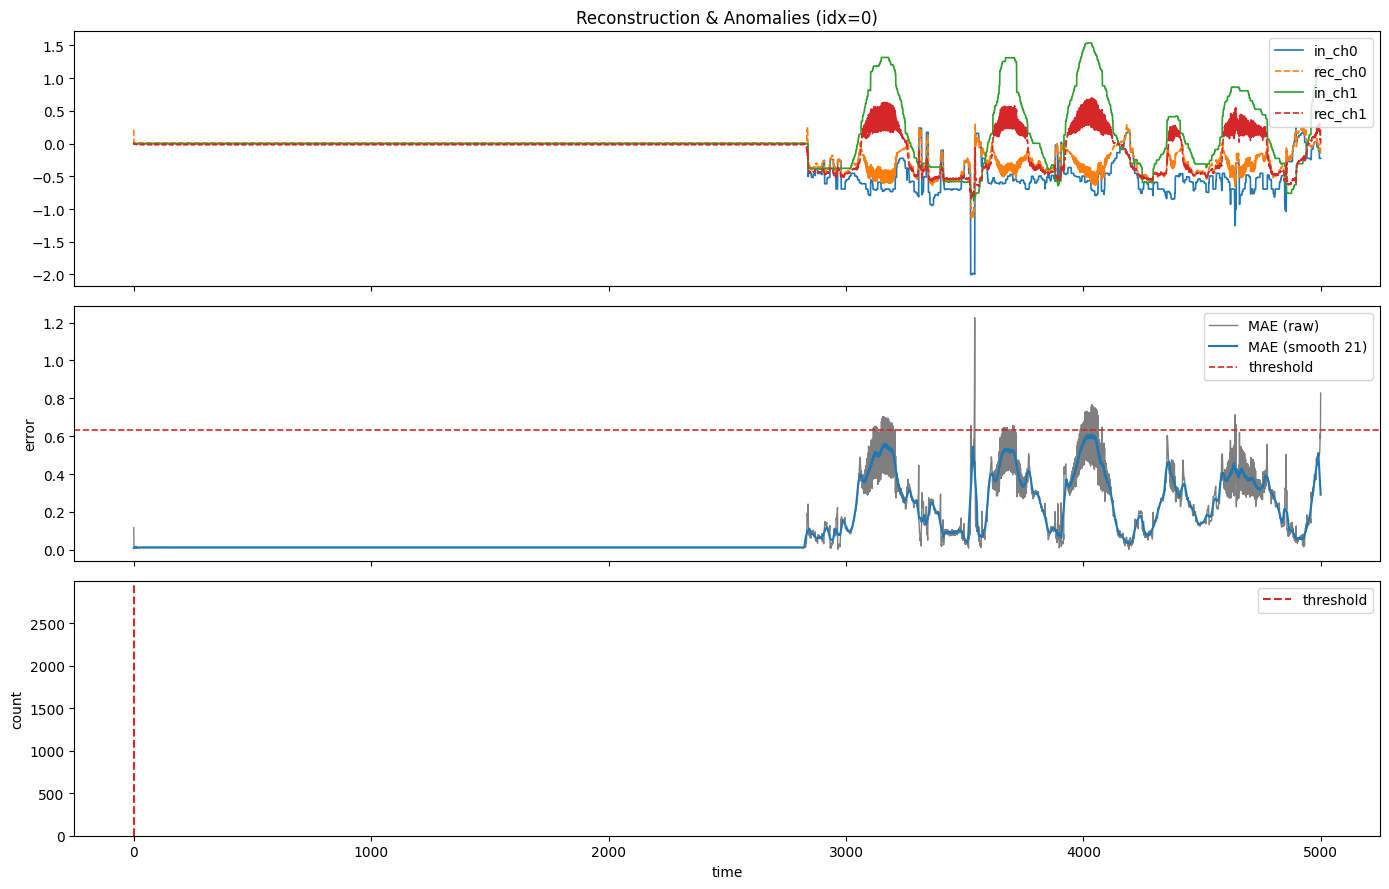

idx=0 anomaly intervals: []


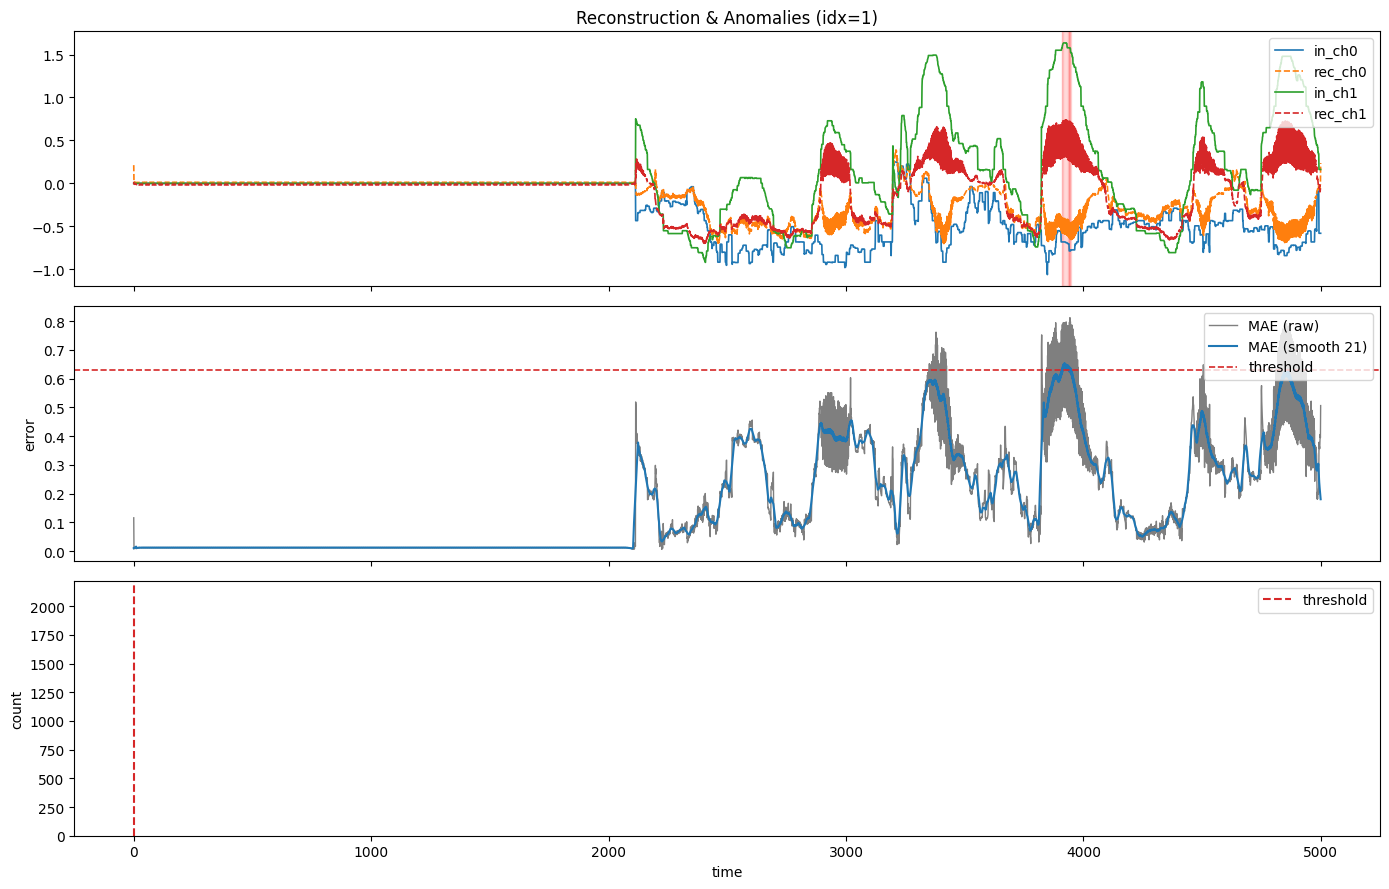

idx=1 anomaly intervals: [(3909, 3909), (3911, 3911), (3913, 3935), (3937, 3937), (3939, 3939), (3941, 3941), (3943, 3943), (3945, 3945), (3947, 3947)]


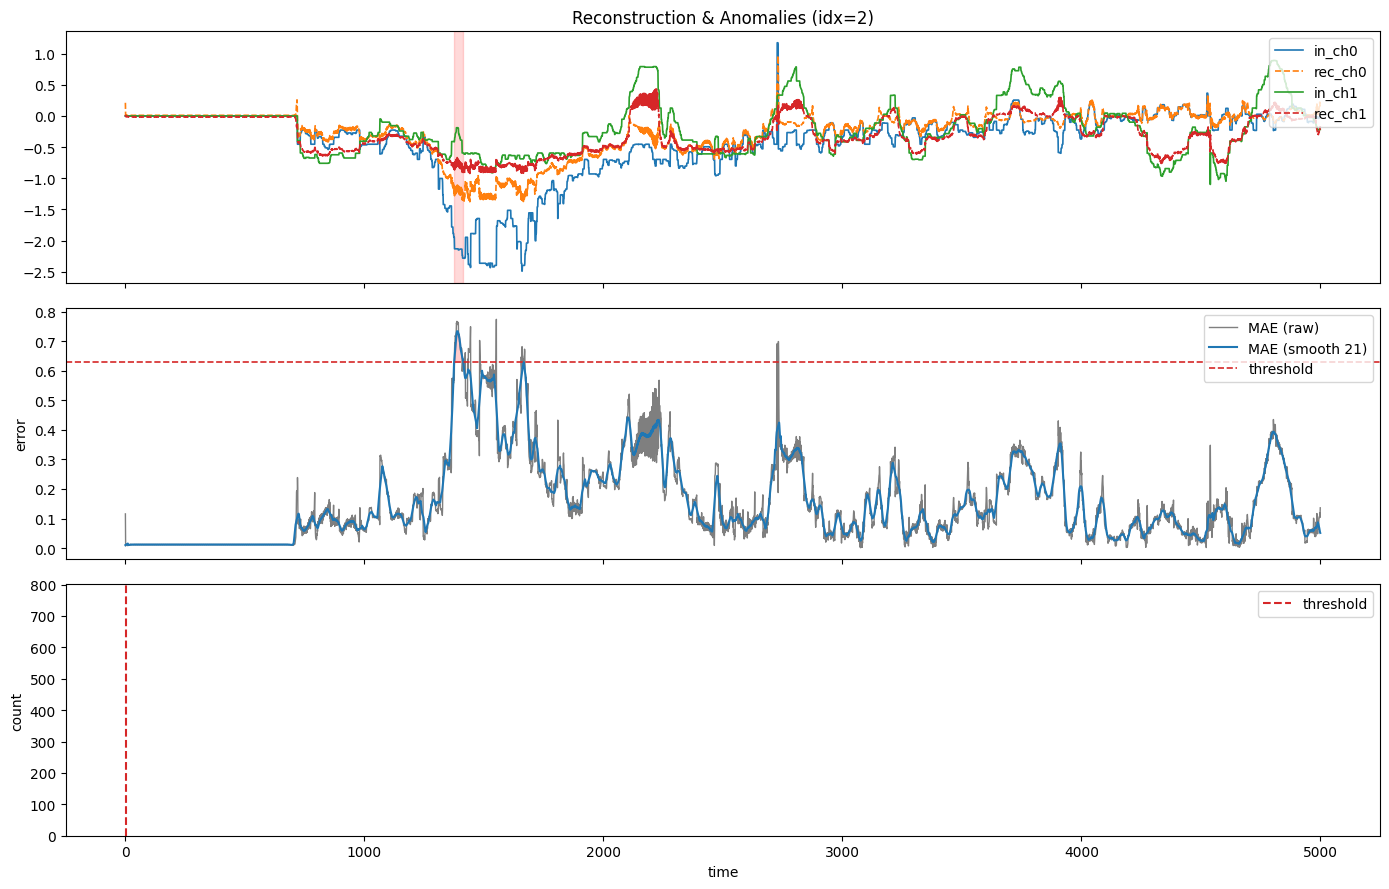

idx=2 anomaly intervals: [(1376, 1413)]


In [56]:
xzinfer()